In [ ]:
import os

#environment variable for Kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [ ]:
import zipfile

with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

Import Libraries & Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import plot_importance
from xgboost import XGBRegressor

Created dataset file at: .gradio\flagged\dataset1.csv


In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (1460, 81)
Test: (1459, 80)


Analyze Missing Data

In [ ]:
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [ ]:
features = ['GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
X = train_df[features]
X = X.fillna(X.mean())  # These features are clean or easy to impute

Text(0.5, 1.0, 'Missing Values per Column')

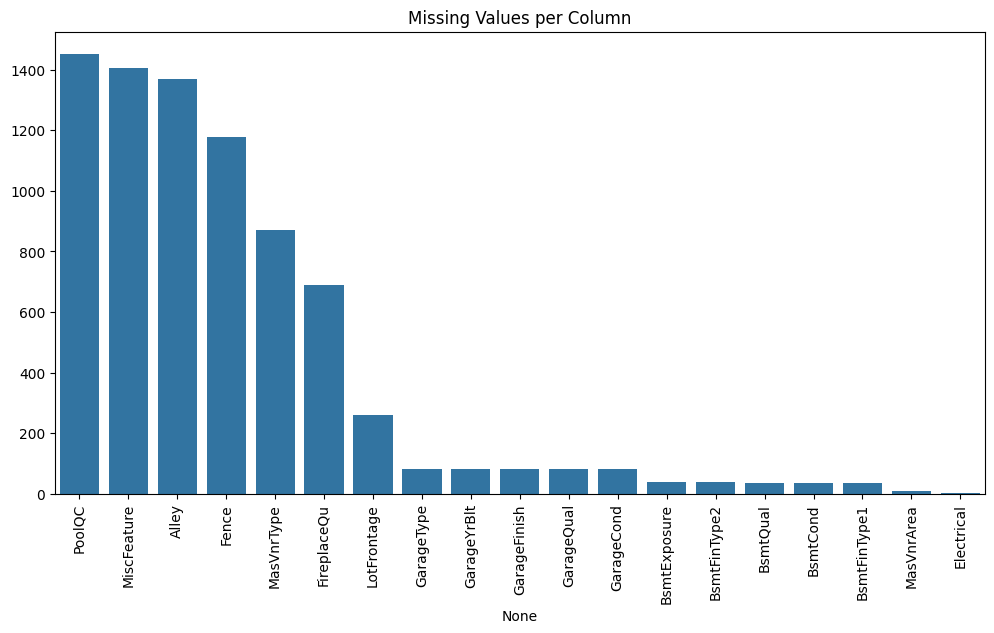

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.title("Missing Values per Column")

Clean Data Properly

In [ ]:
#Drop high-missing columns 
high_missing = missing[missing > 1000].index
train_df = train_df.drop(columns=high_missing, errors='ignore')
test_df = test_df.drop(columns=high_missing, errors='ignore')


#Fill remaining categorical nulls with "None"
cat_cols = train_df.select_dtypes(include="object").columns
for col in cat_cols:
    train_df[col] = train_df[col].fillna("None")
    test_df[col] = test_df[col].fillna("None")

#Fill numeric nulls with median
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    if col != 'SalePrice' and col in test_df.columns:  # ✅ avoid the error here
        test_df[col] = test_df[col].fillna(test_df[col].median())

Encode Categorical Variables

In [ ]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

Train/Test Split

In [ ]:
X = train_df.drop(['SalePrice', 'Id'], axis=1)
y = train_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Train Model

In [20]:
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,  # Try lower learning rate
    max_depth=5,         # Try shallower trees
    subsample=0.8,       # Try different subsampling
    colsample_bytree=0.8,
    reg_alpha=0.1,       # Add L1 regularization
    reg_lambda=1.0,      # Add L2 regularization
    early_stopping_rounds=20,
    eval_metric='rmse',  # Explicitly set metric
    random_state=42
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=True)  # Set to True to see training progress

[0]	validation_0-rmse:86955.87563
[1]	validation_0-rmse:86354.57507
[2]	validation_0-rmse:85733.06226
[3]	validation_0-rmse:85125.86097
[4]	validation_0-rmse:84475.76240
[5]	validation_0-rmse:83906.79509
[6]	validation_0-rmse:83269.13682
[7]	validation_0-rmse:82680.08994
[8]	validation_0-rmse:82073.63795
[9]	validation_0-rmse:81474.34052
[10]	validation_0-rmse:80904.15054
[11]	validation_0-rmse:80359.01890
[12]	validation_0-rmse:79752.41926
[13]	validation_0-rmse:79174.14298
[14]	validation_0-rmse:78620.96582
[15]	validation_0-rmse:78127.28306
[16]	validation_0-rmse:77594.04599
[17]	validation_0-rmse:77131.04576
[18]	validation_0-rmse:76597.23702
[19]	validation_0-rmse:76083.73415
[20]	validation_0-rmse:75574.67808
[21]	validation_0-rmse:75048.97377
[22]	validation_0-rmse:74539.21442
[23]	validation_0-rmse:74084.69084
[24]	validation_0-rmse:73636.67662
[25]	validation_0-rmse:73138.48699
[26]	validation_0-rmse:72614.42545
[27]	validation_0-rmse:72160.25529
[28]	validation_0-rmse:71666.1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

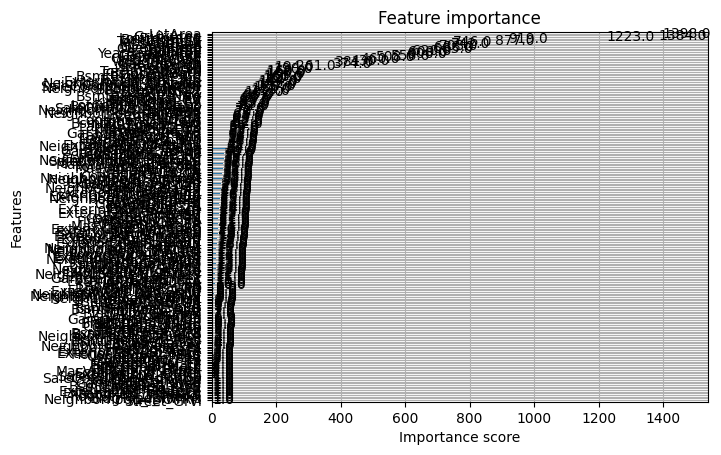

In [27]:
plot_importance(xgb_model)
plt.show()

In [28]:
# Predict on validation set
y_pred = xgb_model.predict(X_val)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Final Validation RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Final Validation RMSE: 24781.91
R² Score: 0.9199


Save the Model

In [ ]:
joblib.dump(xgb_model, 'house_price_xgb_model.pkl')

['house_price_xgb_model.pkl']

In [38]:
def predict_house_price(features):
    """
    Predict house price using the trained model
    
    Args:
        features (DataFrame): Preprocessed features in the same format as training
        
    Returns:
        float: Predicted price
    """
    # Load model
    model = joblib.load('house_price_xgb_model.pkl')
    
    # Make prediction
    return model.predict(features)[0]

# Example usage:
# sample_house = pd.DataFrame([{feature1: value1, feature2: value2,...}])
# predicted_price = predict_house_price(sample_house)

In [ ]:
def gradio_predict(*args):
    # Convert inputs to DataFrame matching training format
    input_dict = {col: [val] for col, val in zip(X_train.columns, args)}
    input_df = pd.DataFrame(input_dict)
    
    # Predict
    prediction = predict_house_price(input_df)
    return f"Predicted Price: ${prediction:,.2f}"

# Create interface
inputs = []
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        inputs.append(gr.Dropdown(label=col, choices=list(X_train[col].unique())))
    else:
        inputs.append(gr.Number(label=col, value=X_train[col].median()))

interface = gr.Interface(
    fn=gradio_predict,
    inputs=inputs,
    outputs="text",
    title="House Price Predictor"
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
